# Overview

**Requirements**
- Project must include 2 models
- At least one using deep learning
- At least one time series prediction


**Notes**
- Build a LSTM to predict 'overall_score' based on other features (satisfies deep learning & time series req.)
- Build a traditional ML classifier to classify important features as bad, average or good for daily notifications in a smart watch




## PROJECT CONSTANTS

In [40]:
GOOGLE_DRIVE_FOLDER_PATH  = "530 Final/IoT AAI-530 Final Project"

DATASET_FILENAME = "sleep_score_data_fitbit.csv"
FITBIT_SLEEP_SCORE_DATASET_URL = f"https://huggingface.co/datasets/aai530-group6/sleep-score-fitbit/resolve/main/{DATASET_FILENAME}?download=true"

## INSTALLS

In [41]:
%%bash
pip install --quiet --progress-bar off \
    isort

## IMPORTS

In [42]:
import contextlib
import hashlib
import os
import pathlib

import google.colab
import isort
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from keras.preprocessing.sequence import pad_sequences
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [43]:
# IMPORT SORTER
import_string = """
import contextlib
import hashlib
import os
import pathlib

import google.colab
import isort
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from keras.preprocessing.sequence import pad_sequences
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
"""
print(isort.code(import_string))


import contextlib
import hashlib
import os
import pathlib

import google.colab
import isort
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from keras.preprocessing.sequence import pad_sequences
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2



## HELPER FUNCTIONS

In [67]:
def compute_hash(file_path: str) -> str:
    """
    Computes the SHA-256 hash for a given file, reading in binary mode and
    processing in blocks for efficiency with large files.

    :param file_path: Path to the file for hash computation.
    :type file_path: str
    :return: Hexadecimal string of the file's SHA-256 hash.
    :rtype: str
    """
    sha256_hash = hashlib.sha256()
    with open(file_path, 'rb') as f:
        for byte_block in iter(lambda: f.read(4096), b""):
            sha256_hash.update(byte_block)
    return sha256_hash.hexdigest()

def should_download(url: str, save_path: str) -> bool:
    """
    Determines if a file should be downloaded by checking its existence and
    comparing the content hash with the online version.

    :param url: URL of the file to potentially download.
    :type url: str
    :param save_path: Local path where the file would be saved.
    :type save_path: str
    :return: True if download is needed, False otherwise.
    :rtype: bool
    """
    try:
        response = requests.get(url, stream=True)
        if response.status_code != 200:
            return False  # DON'T DOWNLOAD IF INACCESSIBLE

        downloaded_hash = hashlib.sha256(response.content).hexdigest()
        if os.path.exists(save_path):
            existing_hash = compute_hash(save_path)
            if existing_hash == downloaded_hash:
                return False  # FILE EXISTS AND IS UP TO DATE

    except Exception as e:
        print(f"An error occurred: {e}")
        return False

    return True


def download(url: str, save_path: str) -> str:
    """
    Downloads a file from a URL to a local path if it's absent or outdated.
    Raises an exception for non-200 HTTP status during download.

    :param url: URL of the file to download.
    :type url: str
    :param save_path: Local path to save the downloaded file.
    :type save_path: str
    :raises Exception: For non-200 HTTP status during download.
    :return: None. Directly writes to disk if download occurs.
    :rtype: None
    """
    if should_download(url, save_path):
        response = requests.get(url)
        if response.status_code != 200:
            raise Exception(f"DOWNLOAD FAILED. STATUS: {response.status_code}")

        with open(save_path, 'wb') as f:
            f.write(response.content)

    print(f"DOWNLOADED FILE: {save_path}.")


def create_google_drive_shortcut(target_folder_name: str = "temp") -> str:
    """
    Creates a shortcut to a Google Drive folder, ensuring easier access by
    mounting Google Drive and creating a symlink in the Colab environment.

    :param target_folder_name: Name of the Google Drive folder for the shortcut.
    :type target_folder_name: str
    :return: Path to the symlink created in the Colab environment.
    :rtype: str
    """
    # MOUNT GOOGLE DRIVE
    with contextlib.redirect_stdout(open(os.devnull, 'w')):
        google.colab.drive.mount("/content/drive", force_remount=True)

    # DEFINE BASE PATHS FOR DRIVE AND SHORTCUTS
    base_drive_path = pathlib.Path("/content/drive/My Drive")
    project_path = base_drive_path / target_folder_name
    shortcut_folder_name = target_folder_name.split('/')[-1]
    shortcut_path = pathlib.Path(f"/content/{shortcut_folder_name}")

    # ENSURE PROJECT FOLDER AND PARENT FOLDERS EXIST IN GOOGLE DRIVE
    project_path.mkdir(parents=True, exist_ok=True)

    # CREATE FOLDER SHORTCUT IF NON-EXISTENT
    if not shortcut_path.exists() or not shortcut_path.is_symlink():
        if shortcut_path.exists():
            shortcut_path.unlink()
        shortcut_path.symlink_to(project_path, target_is_directory=True)
    print(f"FILE PANE SHORTCUT: {shortcut_path} --> {project_path}")

    # RETURN SHORTCUT PATH
    return str(shortcut_path)


## SETUP

In [68]:
# REMOVE SAMPLE DATA FOLDER
!rm -rf /content/sample_data

# CREATE GOOGLE DRIVE FOLDER SHORTCUT FOR SPEED AND PERSISTENCE
SHORTCUT  = create_google_drive_shortcut(GOOGLE_DRIVE_FOLDER_PATH)

# DOWNLOAD DATASET TO GOOGLE DRIVE
DATASET_FILEPATH = os.path.join(SHORTCUT, DATASET_FILENAME)
download(FITBIT_SLEEP_SCORE_DATASET_URL, DATASET_FILEPATH)

FILE PANE SHORTCUT: /content/IoT AAI-530 Final Project --> /content/drive/My Drive/530 Final/IoT AAI-530 Final Project
DOWNLOADED FILE: /content/IoT AAI-530 Final Project/sleep_score_data_fitbit.csv.


## LOAD

In [69]:
dataset_df = pd.read_csv(DATASET_FILEPATH)
dfs = {}
dfs['sleep_score'] = dataset_df
df = dfs['sleep_score']

#Exploratory Data Analysis

In [70]:
df.head(1)

,timestamp,overall_score,revitalization_score,deep_sleep_in_minutes,resting_heart_rate,restlessness
0,2023-11-18T07:59:00Z,83,83,104,63,0.0681


In [71]:
# Datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.sort_values('timestamp', inplace=True)

In [72]:
# Missing values
missing_values = df.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 timestamp                0
overall_score            0
revitalization_score     0
deep_sleep_in_minutes    0
resting_heart_rate       0
restlessness             0
dtype: int64


In [73]:
df.describe()

,overall_score,revitalization_score,deep_sleep_in_minutes,resting_heart_rate,restlessness
count,291.000000,291.000000,291.000000,291.000000,291.000000
mean,75.189003,75.189003,91.292096,62.171821,0.067268
std,7.614552,7.614552,28.807337,2.831722,0.021966
min,45.000000,45.000000,18.000000,55.000000,0.032702
25%,70.000000,70.000000,69.500000,60.000000,0.052605
50%,76.000000,76.000000,91.000000,62.000000,0.062626
75%,81.500000,81.500000,110.500000,64.000000,0.077261
max,89.000000,89.000000,179.000000,70.000000,0.185596


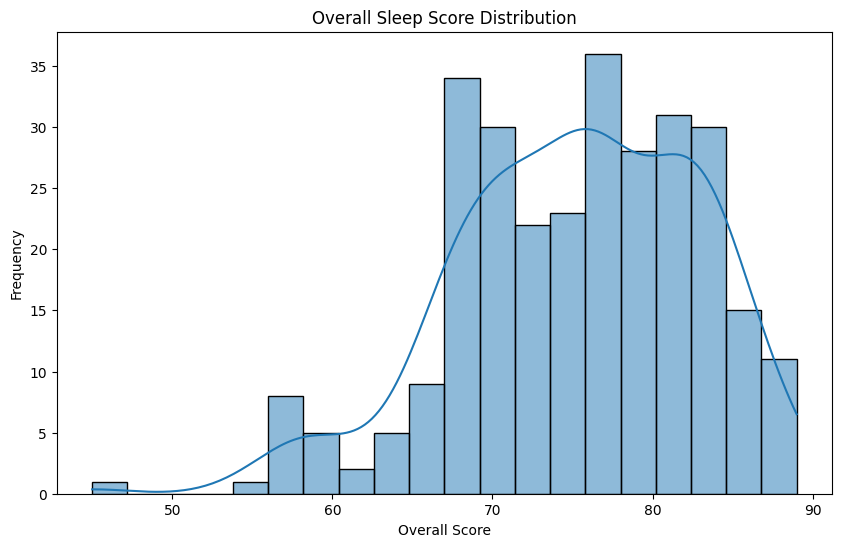

In [74]:
# Distribution of Overall Sleep Score
plt.figure(figsize=(10, 6))
sns.histplot(df['overall_score'], kde=True, bins=20)
plt.title('Overall Sleep Score Distribution')
plt.xlabel('Overall Score')
plt.ylabel('Frequency')
plt.show()

<ipython-input-75-505e2d532d6e>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")


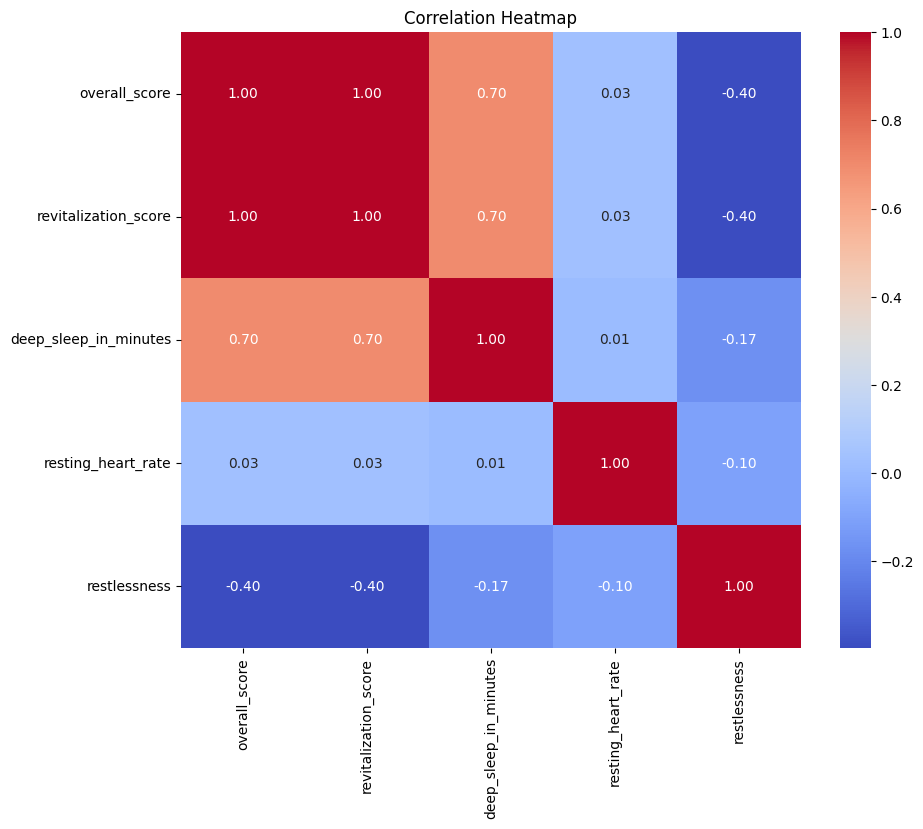

In [75]:
## Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Notes

- Target variable: 'overall_score'
- 'deep_sleep_in_minutes' has a high correlation of 0.70
- 'restlessness' has a notable negative correlation of -0.40

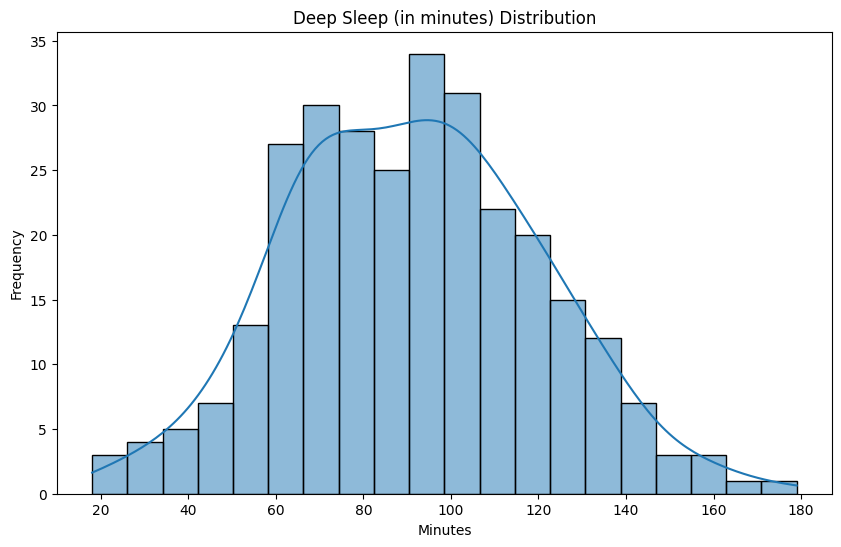

In [76]:
# Distribution of Deep Sleep
plt.figure(figsize=(10, 6))
sns.histplot(df['deep_sleep_in_minutes'], kde=True, bins=20)
plt.title('Deep Sleep (in minutes) Distribution')
plt.xlabel('Minutes')
plt.ylabel('Frequency')
plt.show()

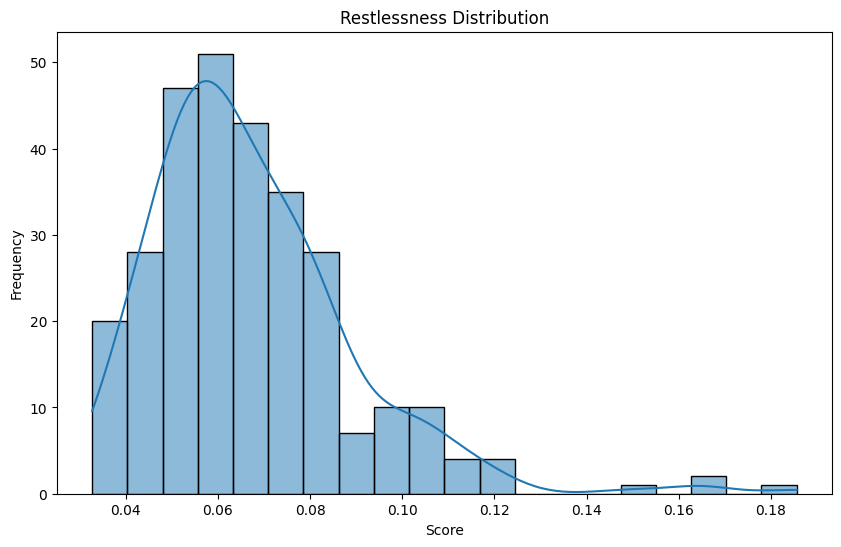

In [77]:
# Distribution of Restlessness
plt.figure(figsize=(10, 6))
sns.histplot(df['restlessness'], kde=True, bins=20)
plt.title('Restlessness Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

Feature Engineering

- Add lagged features
- Add noise

In [78]:
# Lag features for 'deep_sleep_in_minutes' and 'overall_score'
for lag in range(1, 8):
    df[f'deep_sleep_in_minutes_lag{lag}'] = df['deep_sleep_in_minutes'].shift(lag)
    df[f'overall_score_lag{lag}'] = df['overall_score'].shift(lag)

# Drop rows with NaN values created by lagging
df.dropna(inplace=True)

In [79]:
# Add noise to features (excluding 'timestamp' and 'overall score')
noise_strength = 0.01
features_to_noise = ['deep_sleep_in_minutes', 'resting_heart_rate', 'restlessness'] + [f'deep_sleep_in_minutes_lag{lag}' for lag in range(1, 8)]
for feature in features_to_noise:
    df[feature] += np.random.normal(0, noise_strength, df.shape[0])

# LSTM

Traditional ML Classifier

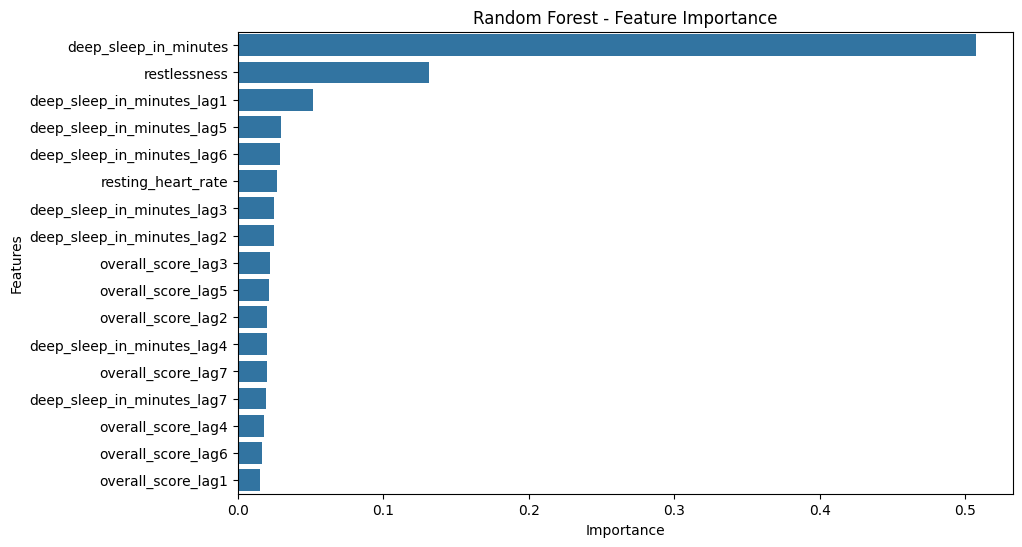

In [82]:
target = df['overall_score']
features_columns = ['deep_sleep_in_minutes', 'resting_heart_rate', 'restlessness'] + \
                   [f'deep_sleep_in_minutes_lag{lag}' for lag in range(1, 8)] + \
                   [f'overall_score_lag{lag}' for lag in range(1, 8)]

features = df[features_columns]

# Feature importances
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(features, target)

importances = rf.feature_importances_
importances_series = pd.Series(importances, index=features_columns)
sorted_importances = importances_series.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importances, y=sorted_importances.index)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Random Forest - Feature Importance')
plt.show()

In [83]:
# Bin deep sleep based on z-scores
mean = df['deep_sleep_in_minutes'].mean()
std_dev = df['deep_sleep_in_minutes'].std()
df['z_score'] = (df['deep_sleep_in_minutes'] - mean) / std_dev
df['deep_sleep_category'] = df['z_score'].apply(lambda z: 'Poor' if z < -1 else ('Average' if z < 1 else 'Good'))

# Bin restlessness based on z-scores
mean_restlessness = df['restlessness'].mean()
std_dev_restlessness = df['restlessness'].std()
df['z_score_restlessness'] = (df['restlessness'] - mean_restlessness) / std_dev_restlessness
df['restlessness_category'] = df['z_score_restlessness'].apply(lambda z: 'Low' if z < -1 else ('Average' if z < 1 else 'High'))

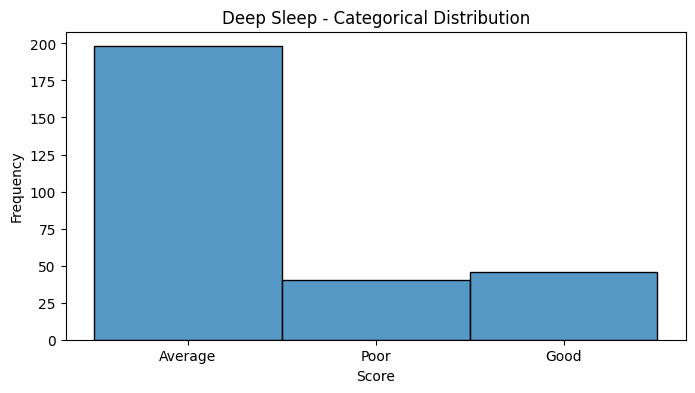

In [84]:
# Distribution of Deep Sleep - Categorical Variable
plt.figure(figsize=(8, 4))
sns.histplot(df['deep_sleep_category'], kde=False, bins=20)
plt.title('Deep Sleep - Categorical Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

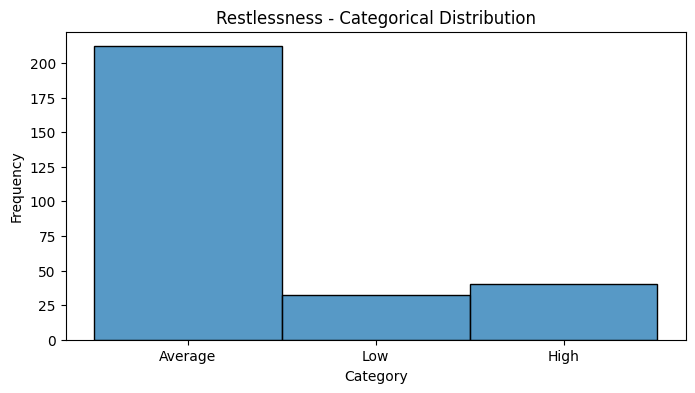

In [85]:
# Plot the distribution of the restlessness categories
plt.figure(figsize=(8, 4))
sns.histplot(df['restlessness_category'], kde=False, bins=20)
plt.title('Restlessness - Categorical Distribution')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.show()

# Deep Learning Neural Network

In [86]:
# Define the sequence length and predictive horizon
sequence_length = 7
predictive_horizon = 1

# Set target, features, and exclude 'revitalization_score' due to 1.0 correlation with target
features_columns = ['deep_sleep_in_minutes', 'resting_heart_rate', 'restlessness'] + \
                   [f'deep_sleep_in_minutes_lag{lag}' for lag in range(1, 8)] + \
                   [f'overall_score_lag{lag}' for lag in range(1, 8)]

features = df[features_columns]
target = df['overall_score']

# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

X = []
y = []

# Generate sequences for feedforward neural network
for i in range(len(scaled_features) - sequence_length - predictive_horizon + 1):
    X.append(scaled_features[i:i + sequence_length].flatten())
    y.append(target.iloc[i + sequence_length + predictive_horizon - 1])

X = np.array(X)
y = np.array(y)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define the feedforward neural network model
model = Sequential()

# Dense layers
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=150, batch_size=32, validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

# Evaluate the model on the validation set
val_loss, val_mse, val_mae = model.evaluate(X_val, y_val)

print(f"Validation Loss: {val_loss}")
print(f"Validation Mean Squared Error: {val_mse}")
print(f"Validation Mean Absolute Error: {val_mae}")


Epoch 1/150
7/7 [==============================] - 5s 173ms/step - loss: 5435.1963 - mse: 5435.1963 - mae: 73.3127 - val_loss: 5919.3438 - val_mse: 5919.3438 - val_mae: 76.6479
Epoch 2/150
7/7 [==============================] - 0s 15ms/step - loss: 5190.6460 - mse: 5190.6460 - mae: 71.6182 - val_loss: 5640.9829 - val_mse: 5640.9829 - val_mae: 74.8124
Epoch 3/150
7/7 [==============================] - 0s 13ms/step - loss: 4891.8154 - mse: 4891.8154 - mae: 69.4990 - val_loss: 5271.2524 - val_mse: 5271.2524 - val_mae: 72.3022
Epoch 4/150
7/7 [==============================] - 0s 13ms/step - loss: 4492.4844 - mse: 4492.4844 - mae: 66.5385 - val_loss: 4749.6494 - val_mse: 4749.6499 - val_mae: 68.6024
Epoch 5/150
7/7 [==============================] - 0s 13ms/step - loss: 3990.9573 - mse: 3990.9573 - mae: 62.6159 - val_loss: 4071.0432 - val_mse: 4071.0432 - val_mae: 63.4650
Epoch 6/150
7/7 [==============================] - 0s 14ms/step - loss: 3314.3757 - mse: 3314.3757 - mae: 56.8427 - val

# Visualizing Validation and MAE

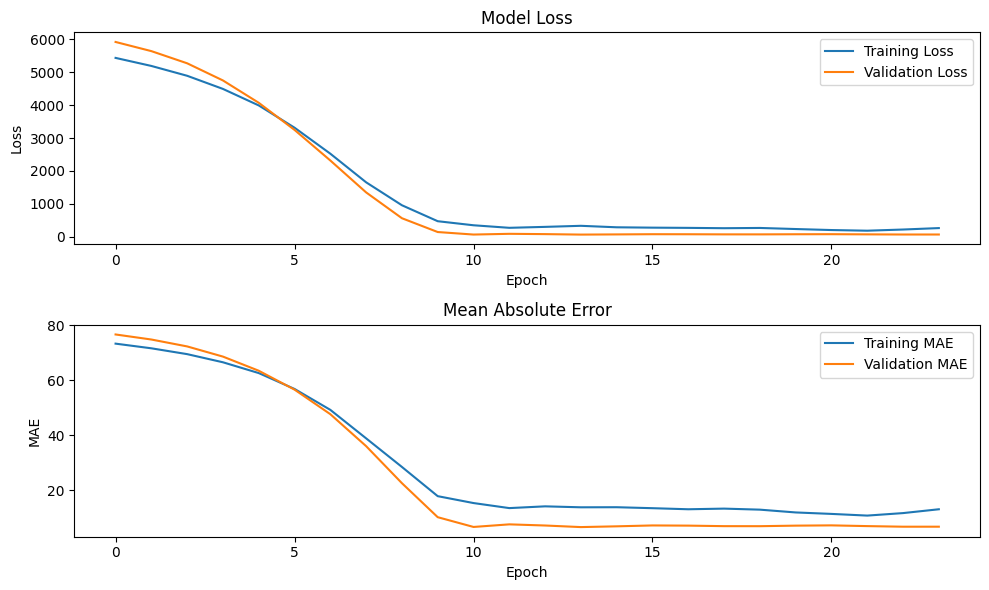

In [87]:
# Plot training history
plt.figure(figsize=(10, 6))

# Plot training & validation loss values
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation mean absolute error values
plt.subplot(2, 1, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Hyperparameter Tuning

In [ ]:
# Define the function to create the model
def create_model(units_layer1=64, dropout_rate=0.5, units_layer2=32, optimizer='adam'):
    model = Sequential()
    model.add(Dense(units_layer1, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units_layer2, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse', 'mae'])
    return model

# Define the hyperparameter grid
param_grid = {
    'units_layer1': [32, 64, 128],
    'dropout_rate': [0.3, 0.5, 0.7],
    'units_layer2': [16, 32, 64],
    'optimizer': ['adam', 'rmsprop']
}

# Perform GridSearchCV
best_model = None
best_val_mse = float('inf')

for units_layer1 in param_grid['units_layer1']:
    for dropout_rate in param_grid['dropout_rate']:
        for units_layer2 in param_grid['units_layer2']:
            for optimizer in param_grid['optimizer']:
                # Create the model
                model = create_model(units_layer1, dropout_rate, units_layer2, optimizer)

                # Train the model
                model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

                # Evaluate on validation set
                y_pred = model.predict(X_val)
                val_mse = mean_squared_error(y_val, y_pred)

                # Check if it's the best model
                if val_mse < best_val_mse:
                    best_val_mse = val_mse
                    best_model = model

# Print the best hyperparameters
print("Best Hyperparameters: ", best_model.get_config())

# Evaluate the best model on the validation set
y_pred = best_model.predict(X_val)
val_mse = mean_squared_error(y_val, y_pred)
val_mae = mean_absolute_error(y_val, y_pred)

print(f"Validation Mean Squared Error: {val_mse}")
print(f"Validation Mean Absolute Error: {val_mae}")

2/2 [==============================] - 0s 6ms/step


# TODO:

Idea: try to predict how you're going to sleep the next day based on prior data.

Smart Watch Sleep Tracker - you're predicted to sleep poorly.
Time Series Predictor

Level of Deep Sleep was low (last night)
Be on the look outout

## BRANDON

* [ ] Refining the model and the CV.

## ALEC

* [ ] Do RF technique
* [ ] First part of documentation
* [ ] Classification work

## DIAGRAMS

1. [ ] DIAGRAM 1: ML1. LOSS GRAPHS
2. [ ] DIAGRAM 2: ML2. MAE
3. [ ] DIAGRAM 3: SUMMARY GRAPH - whatever major feature
4. [ ] DIAGRAM 4: STATUS GRAPH - current status of IOT device (perhaps next day)

MESSAGES
- STATUS:

[ ] Create system diagram









Similar to Assignment 5, your submitted Tableau Public Dashboard must include:
- At least one status visualization - This visualization should tell the dashboard user something about the “current” status of their IoT device (e.g. number of devices online, current glucose level, etc.)

- At least one summary visualization - This visualization should tell the dashboard user
something about the historical data from their IoT device (e.g. average device downtime
over the last week, number of hypo/hyperglycemic readings over the last week)
- At least one visualization for each of your two machine learning insights -
This visualization should communicate the insights created by your machine
learning methods.
